In [ ]:
! pip install networkx

In [95]:
! pip install graph-tools

You should consider upgrading via the '/Users/charlotteout/anaconda3/bin/python -m pip install --upgrade pip' command.


Week 1 implementation of majority model as defined in Peleg-Elite paper + several extensions. 

In [96]:
import networkx as nx
import os
import matplotlib.pyplot as plt
import random
from random import randint, choice
import pandas as pd
import random 


from graph_tools import Graph
import numpy as np
import pickle
import matplotlib.pyplot as plt
from IPython.display import Image

In [3]:
#change directory 
os.chdir("/Users/charlotteout/Documents/semester_project/networks")

# Honest voting process on Facebook Graph

Here we create a simulation of the majority model, as described in Peleg-Elite section 3. Each node adopts the opinion which is the majority of the opinion of its neighbours. This is a basic simulation, and here we do not consider a elite set yet.

In [174]:
def simulation(our_graph):
    #random assignment
    for i in range(len(our_graph.nodes)):
        our_graph.nodes[i]['vote'] = randint(0,1)
        
        if our_graph.nodes[i]['vote'] == 0:
            our_graph.nodes[i]['color'] = 'r'
        if our_graph.nodes[i]['vote'] == 1:
            our_graph.nodes[i]['color'] = 'b'
    node_color = [our_graph.nodes[v]['color'] for v in our_graph]
    nx.draw_spring(our_graph, node_color=node_color, edge_color='#A0CBE2', node_size=10)
    plt.show()
    
    #update step
    change=2
    while change !=0:
        change = 0
        for i in range(len(our_graph.nodes)):
            total_vote = 0
            for j in our_graph.adj[i]:
                total_vote = our_graph.nodes[j]['vote'] + total_vote
                if total_vote == 0:
                    ratio = 0
                else:
                    ratio = total_vote/(len(our_graph.adj[i]))
            if ratio < 0.5:
                if our_graph.nodes[i]['vote'] != 0:
                    change= 1 + change
                our_graph.nodes[i]['vote'] = 0
                our_graph.nodes[i]['color'] = 'r'
            else:
                if our_graph.nodes[i]['vote'] != 1:
                    change= 1 + change
                our_graph.nodes[i]['vote']= 1 
                our_graph.nodes[i]['color']='b'
        print("number of changed opinions", change)
        node_color = [our_graph.nodes[v]['color'] for v in our_graph]
        #plot the network
        nx.draw_spring(our_graph, node_color=node_color, edge_color='#A0CBE2', node_size=10)
        plt.show()
        if change == 0:
            print("no change anymore")
            return

        
        
        
        

In [126]:
#loading a couple of networks into graph objects

#facebook graph (SNAP)
G_fb = nx.read_edgelist("facebook_combined.txt", create_using = nx.Graph(), nodetype=int)
input_data = pd.read_csv('ITALIAN_GANGS.csv', index_col=0)
#italian gang graph (COVERT NETWORKS)
G_italian_gang = nx.Graph(input_data.values)
input_data = pd.read_csv("LONDON_GANG.csv", index_col=0)
#london gang graph (COVERT NETWORKS)
G_london_gang = nx.Graph(input_data.values)
#twitter graph (SNAP)
G_twitter = nx.read_edgelist("twitter_combined.txt", create_using = nx.Graph(), nodetype=int)
#lastmf asian network DOESNT WORK?
G_asian_mf = nx.read_edgelist("lastfm_asia_edges.csv", create_using = nx.Graph(), nodetype=int)

In [176]:
#defining some randomly generated graphs to perform the simulation on 

G_complete = nx.complete_graph(100)
G_er = nx.gnp_random_graph(100, 0.1)
G_ws = nx.watts_strogatz_graph(100, 3, 0.2)
G_ba = nx.barabasi_albert_graph(100, 5)

# Running the simulations

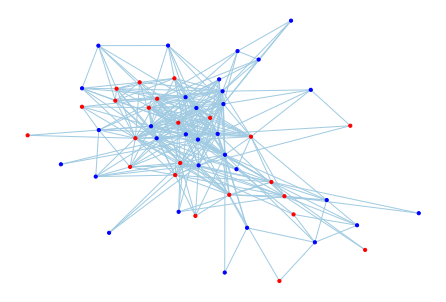

number of changed opinions 27


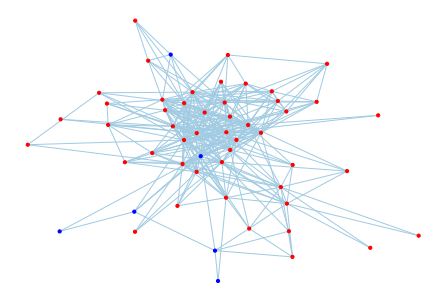

number of changed opinions 5


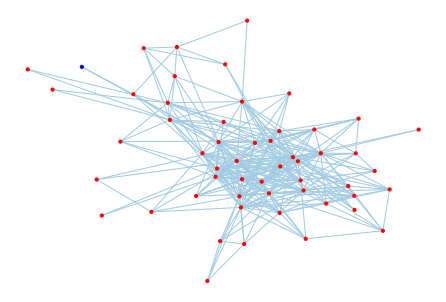

number of changed opinions 1


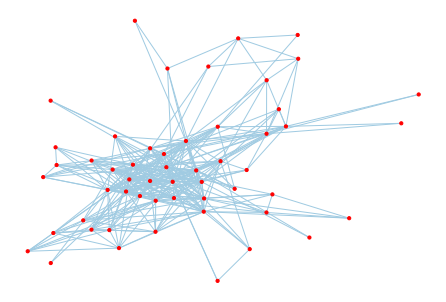

number of changed opinions 0


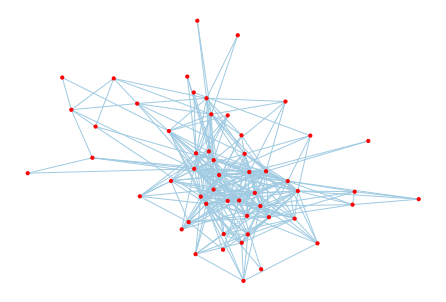

no change anymore


In [159]:
#always goes to purple, this is a mistake! fix this 
simulation(G_london_gang)

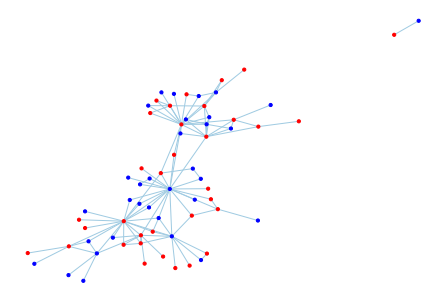

number of changed opinions 28


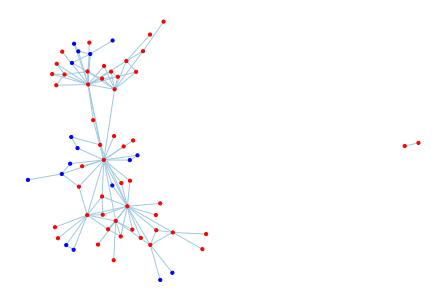

number of changed opinions 3


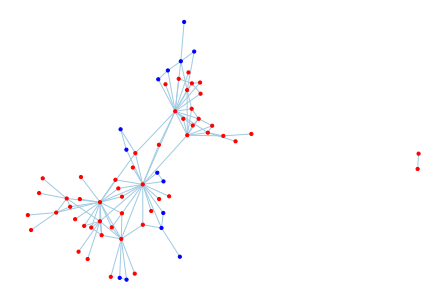

number of changed opinions 0


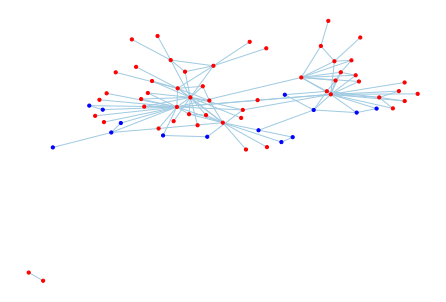

no change anymore


In [160]:
simulation(G_italian_gang)

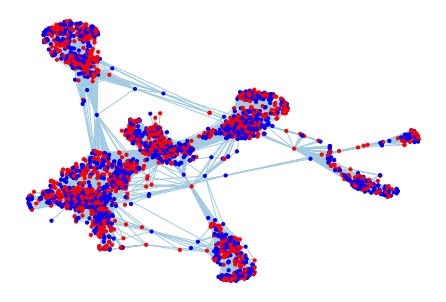

number of changed opinions 1856


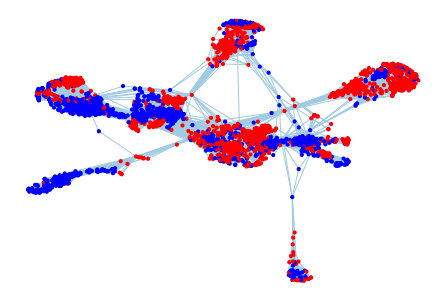

number of changed opinions 382


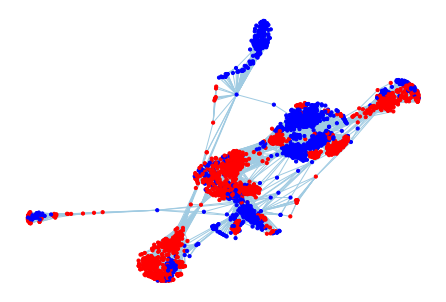

number of changed opinions 55


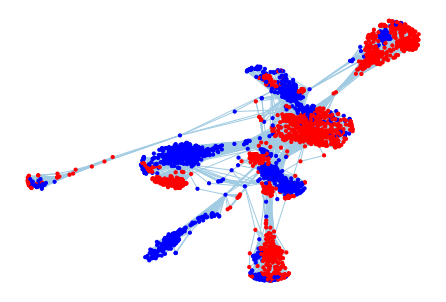

number of changed opinions 9


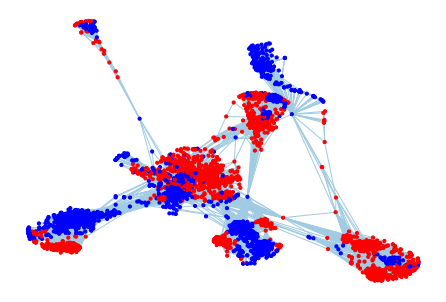

number of changed opinions 0


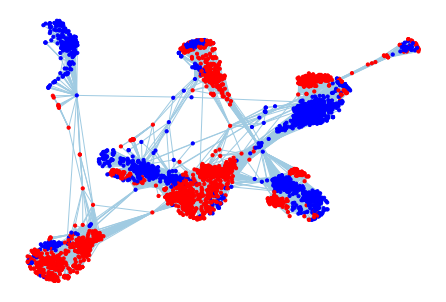

no change anymore


In [161]:
simulation(G_fb)

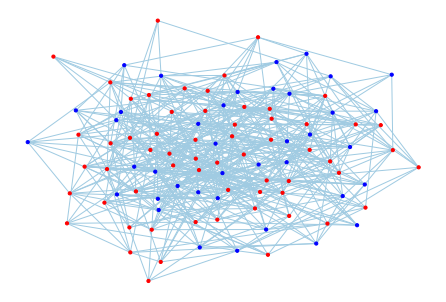

number of changed opinions 40


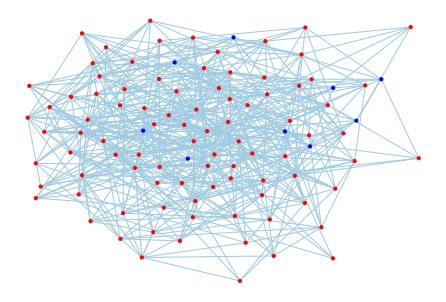

number of changed opinions 9


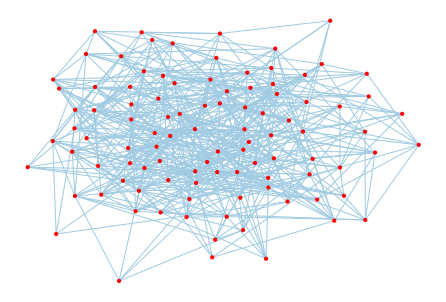

number of changed opinions 0


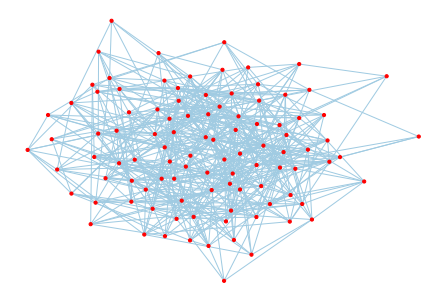

no change anymore


In [177]:
simulation(G_er)

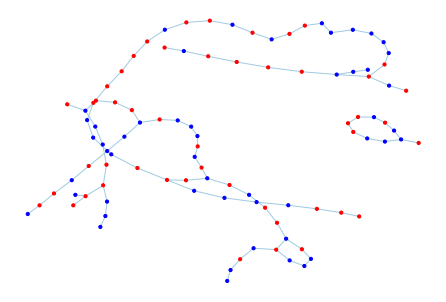

number of changed opinions 47


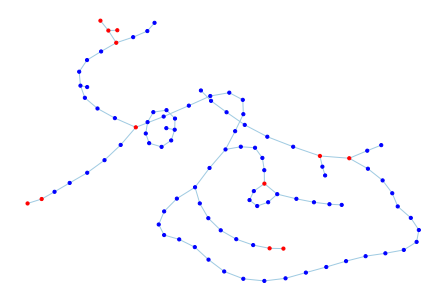

number of changed opinions 7


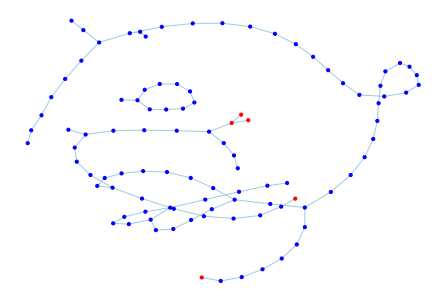

number of changed opinions 2


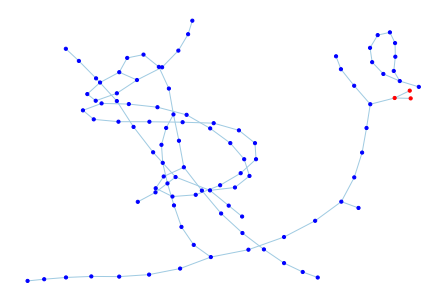

number of changed opinions 0


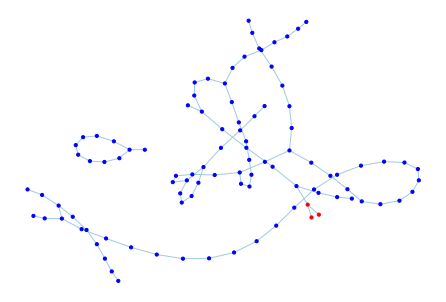

no change anymore


In [178]:
simulation(G_ws)

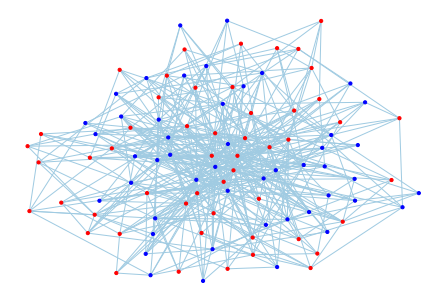

number of changed opinions 51


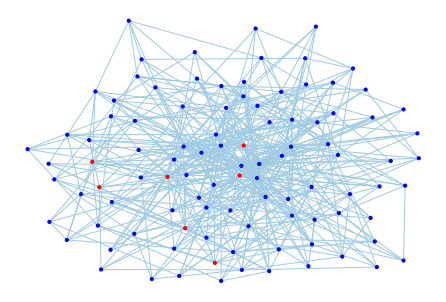

number of changed opinions 7


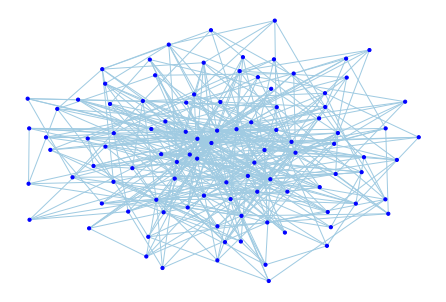

number of changed opinions 0


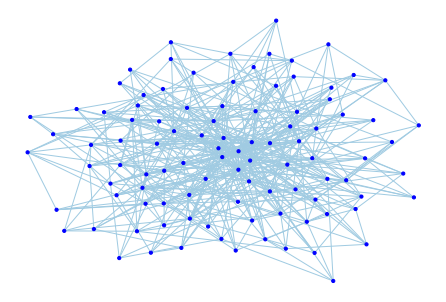

no change anymore


In [180]:
simulation(G_ba)

TODO: add weights!!

# Voting Elite Experiment, both Honest and Dishonest

1. Can a relatively small coalition, say of size sub-linear in the population size, be a monopoly? Does providing the coalition with higher influence factor have a significant impact? If so, should this factor be a function of the population size or would a constant increase suffice?

3. How significant is the effect of “playing fair”? Is there a significant difference in the required monopoly size between the reversible and irreversible modes?


In [294]:
def elite_experiment_honest(our_graph, elite_percentage, elite_way, inf_f, honest):
    """
    our_graph: a networkx graph object
    elite_percentage: float between 0 and 1
    elite_way: 
    0 : arbitrary set of nodes defined as the elite
    1 : highest degree nodes defined as the elite
    2 : highest closeness centrality nodes defined as the elite
    3 : highest betweenness centrality nodes defined as the elite 
    
    influence_factor: integer, with what the weight the vote is multplied
    honest: boolean, if we are in the reversible (honest) or irreversible (dishonest) setting
    """
    num_nodes = len(our_graph.nodes)
    elite_size = int(elite_percentage * num_nodes)
    
    if elite_way == 1:
        #initialization if we define the elite to be the highest degree nodes 
        degrees = [val for (node, val) in sorted(our_graph.degree(), key=lambda pair: pair[0])]
        threshold = sorted(degrees, reverse=True)[:elite_size][-1]

        for (node,degrees) in our_graph.degree():
            if degrees > threshold - 1:
                our_graph.nodes[node]['vote']=1 
                our_graph.nodes[node]['color']='b'
                our_graph.nodes[node]['influence'] = inf_f
                our_graph.nodes[node]['elite'] = 1
            if degrees < threshold:
                our_graph.nodes[node]['vote']=0
                our_graph.nodes[node]['color']='r'
                our_graph.nodes[node]['influence'] = 1
                our_graph.nodes[node]['elite'] = 0
            
    
    if elite_way == 0: 
        #initialization for arbitrary definition of elite 
        #shuffle the nodes and then pick the first ones.
        num_nodes = len(our_graph.nodes)
        node_list = np.arange(num_nodes)
        random.shuffle(node_list)
        elite_node_list = node_list[:elite_size]
        
        #first initialize all of them as vote 0, and then change the elite votes later
        for i in range(len(our_graph.nodes)):
            our_graph.nodes[i]['vote'] = 0
            our_graph.nodes[i]['color'] = 'r'
            our_graph.nodes[i]['influence'] = 1
            our_graph.nodes[i]['elite'] = 0

        for i in elite_node_list:
            our_graph.nodes[i]['vote'] = 1
            our_graph.nodes[i]['color'] = 'b'
            our_graph.nodes[i]['influence'] = inf_f
            our_graph.nodes[i]['elite'] = 1
        
     
    #initialization for highest closeness centrality of elite 
    if elite_way == 2:
        CClist = nx.closeness_centrality(our_graph)
        CClist_S = sorted(CClist.items(), key=lambda x: x[1], reverse=True)
        elite_node_list = CClist_S[:elite_size]
        print(elite_node_list)
        print(len(elite_node_list))
        
        #first initialize all of them as vote 0, and then change the elite votes later
        for i in range(len(our_graph.nodes)):
            our_graph.nodes[i]['vote'] = 0
            our_graph.nodes[i]['color'] = 'r'
            our_graph.nodes[i]['influence'] = 1
            our_graph.nodes[i]['elite'] = 0

        for i in elite_node_list:
            our_graph.nodes[i[0]]['vote'] = 1
            our_graph.nodes[i[0]]['color'] = 'b'
            our_graph.nodes[i[0]]['influence'] = inf_f
            our_graph.nodes[i[0]]['elite'] = 1
        
    #initialization for highest betweenness centrality of elite
    if elite_way == 3:
        BClist = nx.betweenness_centrality(our_graph)
        BClist_S = sorted(BClist.items(), key=lambda x: x[1], reverse=True)
        elite_node_list = BClist_S[:elite_size]
        
        #first initialize all of them as vote 0, and then change the elite votes later
        for i in range(len(our_graph.nodes)):
            our_graph.nodes[i]['vote'] = 0
            our_graph.nodes[i]['color'] = 'r'
            our_graph.nodes[i]['influence'] = 1
            our_graph.nodes[i]['elite'] = 0

        for i in elite_node_list:
            our_graph.nodes[i[0]]['vote'] = 1
            our_graph.nodes[i[0]]['color'] = 'b'
            our_graph.nodes[i[0]]['influence'] = inf_f
            our_graph.nodes[i[0]]['elite'] = 1
    
    
    #now color the nodes 
    node_color = [our_graph.nodes[v]['color'] for v in our_graph]
    #plot the network
    nx.draw_spring(our_graph, node_color=node_color, edge_color ='#A0CBE2',node_size=30)
    plt.show()
    
    
    if honest:
        
        change=2
        while change !=0:
            change = 0
            for i in range(len(our_graph.nodes)):
                total_vote = 0
                for j in our_graph.adj[i]:
                    total_vote= our_graph.nodes[j]['vote'] * our_graph.nodes[j]['influence'] + total_vote

                if total_vote == 0:
                    ratio = 0
                else:
                    ratio = total_vote/(len(our_graph.adj[i]))
                    #ASK: is this the right denominator? 

                if ratio < 0.5:
                    if our_graph.nodes[i]['vote'] != 0:
                        change= 1 + change
                    our_graph.nodes[i]['vote'] = 0
                    our_graph.nodes[i]['color'] = 'r'  
                else:
                    if our_graph.nodes[i]['vote'] != 1:
                        change=1 + change
                    our_graph.nodes[i]['vote']=1 
                    our_graph.nodes[i]['color'] = 'b'
            print("number of changed opinions", change)
            node_color = [our_graph.nodes[v]['color'] for v in our_graph]
            #plot the network
            nx.draw_spring(our_graph, node_color=node_color, edge_color = '#A0CBE2',node_size=30)
            plt.show()
            if change == 0:
                return
            
    if not honest:
        
        change=2
        while change !=0:
            change = 0
            for i in range(len(our_graph.nodes)):
                print(our_graph.nodes[i])
                total_vote = 0
                for j in our_graph.adj[i]:
                    total_vote= our_graph.nodes[j]['vote'] * our_graph.nodes[j]['influence'] + total_vote
                
                ratio = total_vote/(len(our_graph.adj[i]))
                if ratio < 0.5:
                    if our_graph.nodes[i]['vote'] != 0 and our_graph.nodes[i]['elite'] == 0:
                        change=1 + change
                    our_graph.nodes[i]['vote'] = 0
                    our_graph.nodes[i]['color'] = 'r'
                else:
                    if our_graph.nodes[i]['vote'] != 1 and our_graph.nodes[i]['elite'] == 0:
                        change=1 + change
                    our_graph.nodes[i]['vote']=1
                    our_graph.nodes[i]['color'] = 'b'
                    
                if our_graph.nodes[i]['elite'] == 1:
                    our_graph.nodes[i]['vote'] = 1
                    our_graph.nodes[i]['color'] = 'b'
            print("number of changed opinions", change)
            node_color = [our_graph.nodes[v]['color'] for v in our_graph]
            #plot the network
            nx.draw_spring(our_graph, node_color=node_color, edge_color = '#A0CBE2',node_size=30)
            plt.show()
            if change == 0:
                return

    
    
            

In [288]:
#all of them are elite somehow

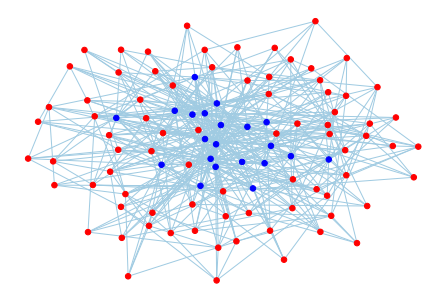

number of changed opinions 21


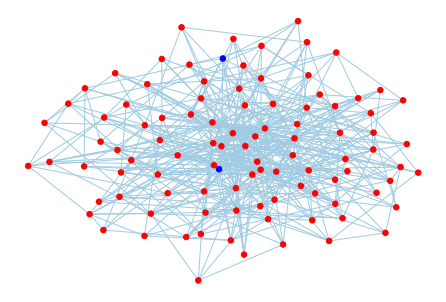

number of changed opinions 2


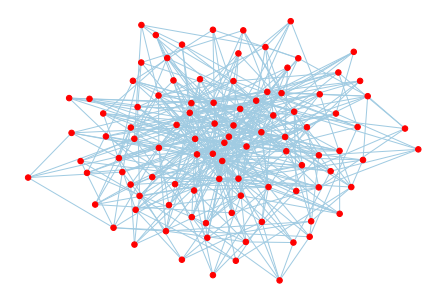

number of changed opinions 0


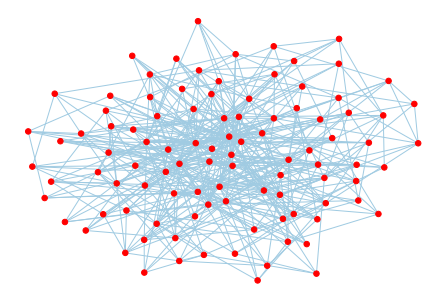

In [299]:
elite_experiment_honest(G_ba, 0.2,1,1, True)

# Dishonest voting process with certain size elite on ER random graph

3. How significant is the effect of “playing fair”? Is there a significant difference in the required monopoly size between the reversible and irreversible modes?

In [ ]:
def elite_experiment_dishonest(elite_size, prob_edge):
    er = nx.gnp_random_graph(100, prob_edge)
    degrees = [val for (node, val) in sorted(er.degree(), key=lambda pair: pair[0])]
    threshold = sorted(degrees, reverse=True)[:elite_size][-1]
    
    for (nodes,degrees) in er.degree():
        if degrees > threshold - 1:
            er.nodes[nodes]['vote']=1
            er.nodes[nodes]['elite']=1
        if degrees < threshold:
            er.nodes[nodes]['vote']=0
            er.nodes[nodes]['elite']=0
    node_color = [er.nodes[v]['vote']+1 for v in er]
    #plot the network
    nx.draw_spring(er, node_color=node_color, node_size=30)
    plt.show()
    
    change=2
    while change !=0:
        change = 0
        for i in range(len(er.nodes)):
            total_vote = 0
            for j in er.adj[i]:
                total_vote= er.nodes[j]['vote'] + total_vote
            #+1 to avoid division by 0
            ratio = total_vote/(len(er.adj[i]) + 1)
            if ratio < 0.5:
                if er.nodes[i]['vote'] != 0 and er.nodes[i]['elite'] == 0:
                    change=1 + change
                er.nodes[i]['vote'] = 0
            else:
                if er.nodes[i]['vote'] != 1 and er.nodes[i]['elite'] == 0:
                    change=1 + change
                er.nodes[i]['vote']=1 
        print("number of changed opinions", change)
        node_color = [er.nodes[v]['vote'] for v in er]
        #plot the network
        nx.draw_spring(er, node_color=node_color, node_size=30)
        plt.show()
        if change == 0:
            return
    

In [ ]:
elite_experiment_dishonest(20, 0.05)

In [ ]:
elite_experiment_dishonest(30, 0.05)

In [ ]:
elite_experiment_dishonest(40, 0.05)